In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import data
import train
from matplotlib import pyplot as plt
import torch

In [13]:
input_dim=16
k=4
batch_size = 256

In [14]:
disjoint_mixed_pool = data.create_mixed_clause_pool_random_disjoint(
    global_input_dim=input_dim,
    pool_size=256,
    features_per_and=4,
    seed=8,
)

In [15]:
L = 1
R = 10
iterations = 1 # increase
T = 10000

stats = []

for num_clauses in range(L, R):
    for it in range(iterations):
        formula = disjoint_mixed_pool[:num_clauses]
        dset = data.create_dataset(
            cset=formula,
            input_dim=input_dim,
            train_size=10000,
            test_size=1000,
            min_true_vars=4,
            max_true_vars=8,
            batch_size=batch_size,
        )
        train_data, test_data = dset
        max_agg_steps = list(range(100, T+100, 100))
        plot_steps = []
        test_loader = data.create_dataloader(test_data, batch_size=batch_size)
        train_loader = data.create_dataloader(train_data, batch_size=batch_size)

        exp, model = train.run_single_model(
            run_name="orig",
            max_aggregator_steps=max_agg_steps,
            plot_steps=plot_steps,
            input_dim=input_dim,
            hidden_dim=input_dim,
            num_features_per_clause=k,
            train_loader=train_loader,
            test_loader=test_loader,
            base_dir=".",
            l2_reg_factor=0,
            l1_reg_factor=1e-4,
            seed_offset=0,
            cset=formula,
            visualize=False,
            loss_diff_th=1e-5,
        )
        train_losses = exp.get_error_history(error_type="train")
        test_losses = exp.get_error_history(error_type="test")
        # print(model.fc1.weight.detach().cpu().numpy())
        cnt_nonzero = (model.fc1.weight.detach().cpu().numpy() > 1e-5).sum()
        print(cnt_nonzero)
        # total params in fc1.weight
        total_params = model.fc1.weight.detach().cpu().numpy().size
        print(total_params)

        l1 = 0.0
        for param in model.parameters():
            l1 += torch.sum(torch.abs(param))
        l1 = l1.item()

        print(train_losses)
        print(test_losses)
        stats.append({
            "train_loss": train_losses[-1],
            "test_loss": test_losses[-1],
            "nonzero_params": cnt_nonzero,
            "total_params": total_params,
            "train_loss_stability": train_losses[-1] - train_losses[-2],
            "test_loss_stability": test_losses[-1] - test_losses[-2],
            "l1": l1
        })

orig: using new random 4-AND formula => [[(8, False), (10, False), (14, False), (15, False)]]
Early stopping: loss variation 0.000008 below threshold 1e-05
Early stopping: loss variation = 0.000008 at step 600
111
256
[0.69862534 0.16824226 0.02810021 0.00960993 0.00457892 0.00260525
 0.00226528]
[5.32552083e-01 1.00000000e-09 1.00000000e-09 1.00000000e-09
 1.00000000e-09 1.00000000e-09 1.00000000e-09]
orig: using new random 4-AND formula => [[(8, False), (10, False), (14, False), (15, False)], [(4, False), (9, False), (11, False), (13, False)]]
Early stopping: loss variation 0.000008 below threshold 1e-05
Early stopping: loss variation = 0.000008 at step 1200
128
256
[0.69763431 0.34175749 0.08483108 0.02617957 0.01137826 0.00604667
 0.0036546  0.00244403 0.0017863  0.00141017 0.00120456 0.00109807
 0.00109236]
[5.76822917e-01 4.68750000e-02 1.00000000e-09 1.00000000e-09
 1.00000000e-09 1.00000000e-09 1.00000000e-09 1.00000000e-09
 1.00000000e-09 1.00000000e-09 1.00000000e-09 1.000000

In [21]:
x = list(range(L, R))
nonzero_params = [s["nonzero_params"] for s in stats]
train_loss = [s["train_loss"] for s in stats]
test_loss = [s["test_loss"] for s in stats]
train_loss_stability = [s["train_loss_stability"] for s in stats]
test_loss_stability = [s["test_loss_stability"] for s in stats]
l1 = [s["l1"] for s in stats]

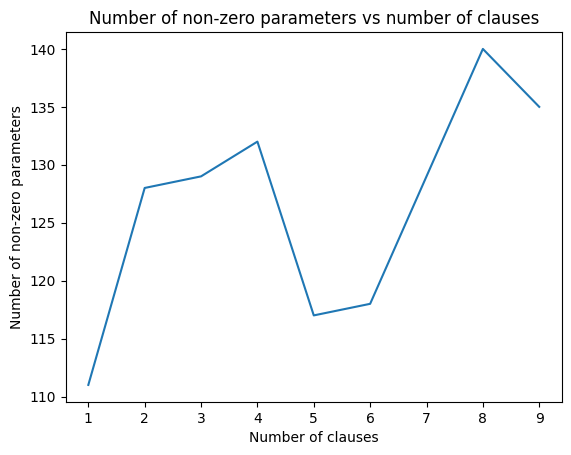

In [22]:
plt.plot(x, nonzero_params)
plt.xlabel("Number of clauses")
plt.ylabel("Number of non-zero parameters")
plt.title("Number of non-zero parameters vs number of clauses")
plt.show()

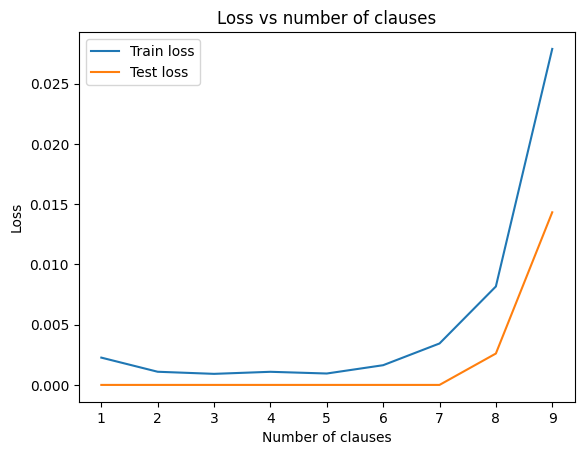

In [23]:
plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.xlabel("Number of clauses")
plt.ylabel("Loss")
plt.title("Loss vs number of clauses")
plt.legend(["Train loss", "Test loss"])
plt.show()

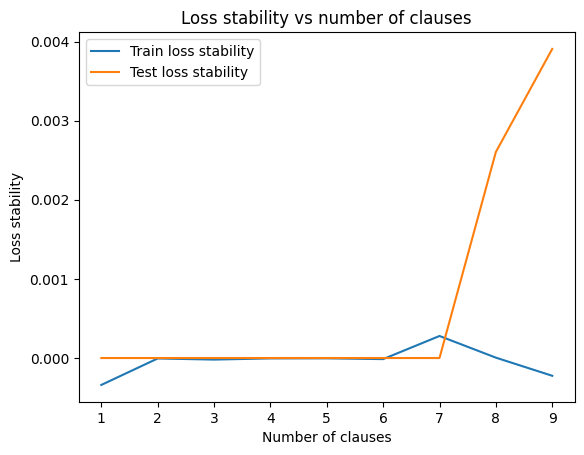

In [24]:
plt.plot(x, train_loss_stability)
plt.plot(x, test_loss_stability)
plt.xlabel("Number of clauses")
plt.ylabel("Loss stability")
plt.title("Loss stability vs number of clauses")
plt.legend(["Train loss stability", "Test loss stability"])
plt.show()

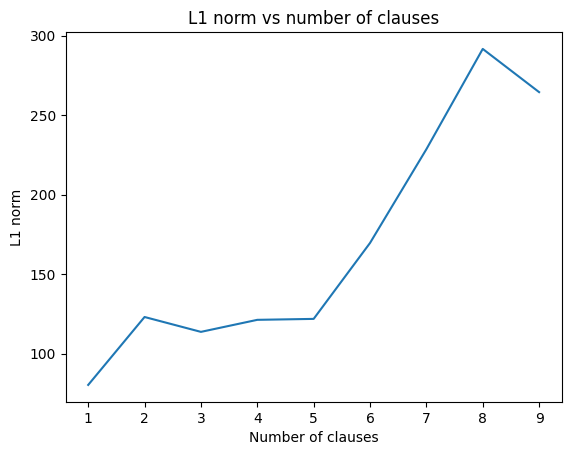

In [25]:
plt.plot(x, l1)
plt.xlabel("Number of clauses")
plt.ylabel("L1 norm")
plt.title("L1 norm vs number of clauses")
plt.show()